### Prediction of Fazekas/clinical scores from uncertainty

we will use the full uncertianty map, on a few selected slices, and attempt to train a model to predict fazekas or clinical scores, and see what they show.

The variance is too high with the sampling from slices model. Lets no go with selecting the maximum slice and see how we go.
I will also change the model size and try a 3D one too.

okay: I have reduced the std of the max slice to zero, and sample now only 1 slice. When using 30 runs, each model is now consistent with itself on the testset, so the
mean accuracy and mode accuracy that we get is genuine. But now I have the problem that different models using the same input channels have high variance in performance. So I need
to clamp that down. I will try to decrease the number of parameters in the model.

turning off augmentation does push the variance down, but it does also push the accuracy down. So I think I should present that using augmentations improves performance and not turn it off. However, I need to see how it affects the validation dataloader (maybe it will make it better reflect the test result which would be welcome).
Right so I have pushed up the number of times the validation dataset is run (with augmentation on), and then I can train 5 models and store the validation results for each model...

In [1]:
# trainer
print("strawberry")
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# data
from trustworthai.utils.data_preprep.dataset_pipelines import load_clinscores_data, load_data, ClinScoreDataRetriever
from torch.utils.data import ConcatDataset, Dataset, DataLoader

# packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
from tqdm import tqdm
from collections import defaultdict
from natsort import natsorted
import torchmetrics
print("banana")

strawberry
banana


In [2]:
### load the data
clin_retriever = ClinScoreDataRetriever(use_updated_scores=True)
split = 0
train_ds_clin, val_ds_clin, test_ds_clin = clin_retriever.load_clinscores_data(
        combine_all=False,
        test_proportion=0.15, 
        validation_proportion=0.12,
        seed=3407,
        cross_validate=True,
        cv_split=split,
        cv_test_fold_smooth=1,

    )

In [3]:
class CustomClinFieldsDataset(torch.utils.data.Dataset):
    # this is just a wrapper on the clinical dataset where I am hard coding a few things, such as one hot encodings, and all the other stuff that
    # I might want to compute like tab fazekas and total fazekas etc
    def __init__(self, base_dataset):
        super().__init__()
        self.base_dataset = base_dataset
        
    def __getitem__(self, idx):
        x, y, clin_data = self.base_dataset[idx]
        r = clin_data.copy()
        
        # smoking
        r['smoking_0'] = (r['smoking'] == 0).astype(np.float32)
        r['smoking_1'] = (r['smoking'] == 1).astype(np.float32)
        r['smoking_2'] = (r['smoking'] == 2).astype(np.float32)
        
        # total fazekas and scale fazekas
        dwmh = r['DWMH']
        pvwmh = r['PVWMH']
        total_fazekas = np.nan
        if (not np.isnan(dwmh)) and (not np.isnan(pvwmh)):
            total_fazekas = dwmh + pvwmh
        r['total_fazekas'] = total_fazekas
        r['scale_fazekas'] = ((pvwmh == 3) | (dwmh > 1)).astype(np.float32)
        
        # scale PVS
        bgpvs = r['BGPVS']
        scale_pvs = np.nan
        if not np.isnan(bgpvs):
            scale_pvs = (bgpvs >= 2).astype(np.float32)
        r['scale_pvs'] = scale_pvs
        
        # scale micrBld
        micrbld = r['micrBld']
        scale_micrbld = np.nan
        if not np.isnan(scale_micrbld):
            scale_micrbld = (micrbld > 0).astype(np.float32)
        r['scale_micrbld'] = scale_micrbld
        
        # stroke_les and scale stroke
        oldLes = r['oldLes']
        relLes = r['relLes']
        stroke_les = np.nan
        scale_stroke = np.nan
        if not np.isnan(oldLes):
            if type(relLes) == str:
                if relLes != ' ':
                    relLes = float(relLes)
                else:
                    relLes = 0.0
            if type(oldLes) == str:
                if oldLes != ' ':
                    oldLes = float(oldLes)
                else:
                    oldLes = 0.0
            try:
                if np.isnan(relLes):
                    relLes = 0.0
            except:
                print("failed on : ", relLes, type(relLes))
            
            try:
                stroke_les = ((oldLes ==1)| (relLes==1)).astype(np.float32)
            except:
                print(f"failed: old:{oldLes}, rel:{relLes}")
            scale_stroke = (oldLes * relLes).astype(np.float32)
        r['stroke_les'] = stroke_les
        r['scale_stroke'] = scale_stroke
            
        return x, y, r
    
    def __len__(self):
        return len(self.base_dataset)

In [4]:
### load the extra information (e.g uncertainty maps, var maps, preds etc)
umap_model_name = "SSN_Ens"
output_maps_dir = f"/home/s2208943/ipdis/data/preprocessed_data/EdData_output_maps/{umap_model_name}/"

output_maps_files = os.listdir(output_maps_dir)

In [5]:
ds = train_ds_clin

def get_output_maps_for_ds(ds):
    output_maps_lists = defaultdict(lambda : [])
    for data in tqdm(ds, position=0, leave=True):
        ID = data[2]['ID']
        output_maps_data = np.load(f"{output_maps_dir}{ID}_out_maps.npz")
        for output_type in output_maps_data.keys():
            output_maps_lists[output_type].append(torch.from_numpy(output_maps_data[output_type]))
            
    return output_maps_lists

In [6]:
### dataset to load in the uncertainty maps and prediction data and add it into the existing dataset.

class AddChannelsDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, extra_x_channels_lists):
        self.base_dataset = base_dataset
        self.extra_x_channels_lists = extra_x_channels_lists
        
    def __getitem__(self, idx):
        data = self.base_dataset[idx]
        x = data[0]
        x = torch.cat([x, *[self.extra_x_channels_lists[key][idx].unsqueeze(0) for key in natsorted(self.extra_x_channels_lists.keys())]], dim=0)
        
        return (x, *data[1:])
        
    def __len__(self):
        return len(self.base_dataset)

In [7]:
### code to select slices - will need to do that randomly, and implement an augmentation procedure (I should add noise maybe)

# a bunch of stuff that I generated with chat-gpt

def find_largest_slice(tensor):
    """
    Find the slice of a PyTorch tensor with the largest sum.
    
    Args:
        tensor: A PyTorch tensor of shape (S, H, W).
        
    Returns:
        A tuple (slice_H, slice_W) representing the slice with the largest sum.
    """
    # Compute the sum along the H and W dimensions
    sum_H = torch.sum(tensor, dim=2)
    sum_W = torch.sum(tensor, dim=1)
    
    # Find the indices with the largest sum
    idx_H = torch.argmax(sum_H)
    idx_W = torch.argmax(sum_W)
    
    # Return the corresponding slices
    return idx_H, idx_W

def compute_std_of_sum(tensor):
    """
    Compute the standard deviation of the sum along H and W dimensions for the given image.
    
    Args:
        tensor: A PyTorch tensor of shape (S, H, W).
        
    Returns:
        A float of standard deviation of the sum along H and W dimensions for the given image.
    """
    # Compute the sum along the H and W dimensions
    sum_HW = torch.sum(tensor, dim=(1, 2))
    
    # Compute the standard deviation of the sum along the H and W dimensions
    #print(tensor.shape, sum_HW.shape)
    std_HW = torch.std(sum_HW, dim=0)
    
    return std_HW.item()

def find_slices_within_std(tensor, t=1.0):
    """
    Find the slices whose sum are within t standard deviations away from the max slice sum for the given image.
    
    Args:
        tensor: A PyTorch tensor of shape (S, H, W).
        t: A float representing the number of standard deviations away from the max slice sum to include.
        
    Returns:
        A list containing the indices of the slices whose sum is within t standard deviations away from the max slice sum in the given image.
    """
    # Compute the sum along the H and W dimensions
    sum_HW = torch.sum(tensor, dim=(1, 2))
    
    # Compute the standard deviation of the sum for each image
    std_sum = compute_std_of_sum(tensor)
    
    # Compute the max slice sum for the image
    max_sum = torch.max(sum_HW, dim=0)[0]
    
    # Compute the threshold for including a slice
    threshold = max_sum - t * std_sum
    
    # Find the slices whose sum is within the threshold for each image
    indices_within_std = torch.where(sum_HW >= threshold)[0].tolist()
    
    if len(indices_within_std) < 3: # edge cases where too few slices are selected.
        indices_within_std += [indices_within_std[-1] + 1, indices_within_std[0] - 1]
    
    return indices_within_std


In [8]:
# generated using chat-gpt.
import torch
import random
from torch.utils.data import Dataset

class SlicesDataset(Dataset):
    """
    A PyTorch Dataset that selects v slices from 3D images within the range of standard deviations of the max slice sum.
    """
    
    def __init__(self, base_dataset, slices_within_std, v, transform=None):
        """
        Initialize the SlicesDataset.
        
        Args:
            base_dataset: A PyTorch Dataset that returns 3D images of shape (C, S, H, W).
            slices_within_std: A list of N lists, where the i-th list contains the indices of the slices whose sum is within t standard deviations away from the max slice sum for the i-th image in the batch.
            v: An integer representing the number of slices to select from each image.
            transform: A function to be applied to both x and y when returning a value from __getitem__. Default is None.
        """
        self.base_dataset = base_dataset
        self.slices_within_std = slices_within_std
        self.v = v
        self.transform = transform
    
    def __getitem__(self, index):
        """
        Select v random slices from the 3D image within the range of standard deviations, and return a tensor of shape (C * v, H, W).
        
        Args:
            index: An integer representing the index of the image to retrieve.
            
        Returns:
            A tuple containing a PyTorch tensor of shape (C * v, H, W) and its corresponding label.
        """
        # Get the original 3D image and its corresponding label
        x_3d, y_3d, clin_data = self.base_dataset[index]
        
        # Get the indices of the slices within the range of standard deviations
        indices_within_std = self.slices_within_std[index]
        
        # Randomly select v slices from the indices within the range of standard deviations
        selected_indices = random.sample(indices_within_std, self.v)
        
        # Select the slices from the 3D image
        x_slices = x_3d[:, selected_indices]
        y_slices = y_3d[:, selected_indices]
        
        # Reshape the slices into C*v 2D tensors
        x_2d = torch.reshape(x_slices, (-1, x_slices.shape[-2], x_slices.shape[-1]))
        y_2d = torch.reshape(y_slices, (-1, y_slices.shape[-2], y_slices.shape[-1]))
        
        # Apply the transform function to both x and y
        if self.transform:
            x_2d, y_2d = self.transform(x_2d, y_2d)
        
        return x_2d, y_2d, clin_data
    
    def __len__(self):
        """
        Return the number of images in the dataset.
        
        Returns:
            An integer representing the number of images in the dataset.
        """
        return len(self.base_dataset)

In [9]:
ds = train_ds_clin


def get_slices_within_std_for_ds(ds, t=2.5):
    # get slices with wmh sum within 3 std of the maximum
    # I could also replace with for slices within 3 std of the max uncertainty?
    slices_within_std = []
    for data in tqdm(ds, position=0, leave=True):
        y = data[1].squeeze()
        slices_within_std.append(find_slices_within_std(y, t=t))
        
    return slices_within_std

In [10]:
slices_within_std_for_ds = get_slices_within_std_for_ds(ds, t=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:00<00:00, 579.44it/s]


In [11]:
slices_within_std_for_ds

[[26, 27, 28, 25],
 [28, 29, 27],
 [25, 26, 24],
 [24, 25, 23],
 [24, 25, 23],
 [25, 26, 27, 24],
 [27, 28, 26],
 [25, 26, 27, 24],
 [25, 26, 24],
 [29, 30, 28],
 [24, 25, 23],
 [23, 24, 22],
 [25, 26, 24],
 [26, 27, 28, 25],
 [25, 26, 24],
 [24, 25, 23],
 [28, 29, 27],
 [26, 27, 28, 25],
 [24, 25, 23],
 [24, 25, 23],
 [24, 25, 23],
 [14, 15, 16, 13],
 [27, 28, 26],
 [26, 27, 28, 25],
 [26, 27, 28, 25],
 [25, 26, 24],
 [26, 27, 28, 25],
 [25, 26, 24],
 [19, 20, 18],
 [24, 25, 23],
 [25, 26, 24],
 [15, 16, 14],
 [27, 28, 26],
 [25, 26, 24],
 [24, 25, 23],
 [25, 26, 24],
 [27, 28, 26],
 [26, 27, 28, 25],
 [29, 30, 31, 28],
 [30, 31, 32, 29],
 [22, 23, 24],
 [29, 30, 28],
 [28, 29, 27],
 [28, 29, 27],
 [30, 31, 32, 29],
 [27, 28, 26],
 [25, 26, 27, 24],
 [28, 29, 27],
 [29, 30, 31, 28],
 [27, 28, 26],
 [28, 29, 27],
 [28, 29, 27],
 [28, 29, 27],
 [32, 33, 31],
 [30, 31, 29],
 [31, 32, 30],
 [34, 35, 33],
 [32, 33, 31],
 [33, 34, 32],
 [33, 34, 32],
 [32, 33, 31],
 [31, 32, 30],
 [34, 35, 

In [12]:
#(torch.Tensor([len(s) for s in slices_within_std_for_ds]))

In [13]:
### defining the augmentation procedure
from trustworthai.utils.augmentation.standard_transforms import (
    RandomFlip, GaussianBlur, GaussianNoise,
    RandomResizeCrop, RandomAffine,
    NormalizeImg, PairedCompose, LabelSelect,
    PairedCentreCrop, CropZDim,
)
import torch


def get_transforms():
    transforms = [
        LabelSelect(label_id=1),
        RandomFlip(p=0.5, orientation="horizontal"),
        # GaussianBlur(p=0.5, kernel_size=7, sigma=(.1, 1.5)),
        # GaussianNoise(p=0.2, mean=0, sigma=0.2),
        RandomAffine(p=0.2, shear=(-18,18)),
        RandomAffine(p=0.2, degrees=15),
        RandomAffine(p=0.2, translate=(-0.1,0.1)),
        RandomAffine(p=0.2, scale=(0.9, 1.1)),
#         #RandomResizeCrop(p=1., scale=(0.6, 1.), ratio=(3./4., 4./3.))

#         #RandomResizeCrop(p=1., scale=(0.3, 0.5), ratio=(3./4., 4./3.)) # ssn
    ]
    transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
    return PairedCompose(transforms)

In [14]:
### combine the clinical scores data into the x information.
# generated with chatgpt
class ClinicalDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, fields, target_field):
        self.base_dataset = base_dataset
        self.fields = fields
        self.target_field = target_field

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, index):
        x, y, clin_data = self.base_dataset[index]
        clin_data_fields = clin_data[self.fields].values
        clin_data_tensor = torch.from_numpy(clin_data_fields.astype(np.float32))
        target_field = clin_data[self.target_field]
        return (x, clin_data_tensor), target_field

In [15]:
# torch dataset that filters out nans
class NonNanDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset
        self.indices = []

        for i in range(len(self.original_dataset)):
            (x, clin_data), y = self.original_dataset[i]
            if not (np.isnan(y) or torch.any(torch.isnan(clin_data))):
                self.indices.append(i)

    def __getitem__(self, index):
        original_index = self.indices[index]
        return self.original_dataset[original_index]

    def __len__(self):
        return len(self.indices)


In [16]:
class RepeatDataset(Dataset):
    def __init__(self, original_dataset, repeats):
        self.original_dataset = original_dataset
        self.repeats=repeats
        
    def __getitem__(self, idx):
        return self.original_dataset[idx % len(self.original_dataset)]
    
    def __len__(self):
        return len(self.original_dataset) * self.repeats

In [17]:
np.isnan(np.nan)

True

In [18]:
### building the combined datasets with 
# augmentation transforms, added in umaps and predictions as channels
# and code to select 3 slices from the image.

def build_clinscores_prediction_dataset(ds, t=2.5, v=3, clin_fields=['age'], target_field='DWMH', apply_augmentation=False):
    
    # sort out the extra fields I need (e.g smoking one hot encoded)
    ds = CustomClinFieldsDataset(ds)
    
    # load in the extra data (e.g umaps) to build a combined dataset
    print("loading umaps and wmh preds images")
    output_maps_test = get_output_maps_for_ds(ds)
    added_channels_ds = AddChannelsDataset(ds, output_maps_test)
    
    # compute which slices have wmh burdern with 3 std of the max
    slices_within_std_for_ds = get_slices_within_std_for_ds(ds, t=t)
    
    # get dataset that randomly samples three slices for each input from within the range of slices within one std
    new_ds = SlicesDataset(added_channels_ds, slices_within_std_for_ds, v=v, transform=get_transforms() if apply_augmentation else None)
    
    # combine the clin scores data into the x
    new_ds = ClinicalDataset(new_ds, clin_fields, target_field)
    
    new_ds = NonNanDataset(new_ds)
    
    return new_ds

In [100]:
t = 0 # 2.5
v = 1 # 
# clin_fields = ['age', 'sex', 'diabetes']
# clin_fields = ['age', 'sex', 'diabetes', 'hypertension', 'hyperlipidaemia', 'smoking_0', 'smoking_1', 'smoking_2', 'ICV']
clin_fields = ['age', 'sex', 'diabetes', 'hypertension', 'hyperlipidaemia', 'smoking_0', 'smoking_1', 'smoking_2']
target_field = "DWMH"
new_test_ds = build_clinscores_prediction_dataset(test_ds_clin, t=t, v=v, clin_fields=clin_fields, target_field=target_field,  apply_augmentation=False)

loading umaps and wmh preds images


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 78.55it/s]


In [112]:
new_val_ds = build_clinscores_prediction_dataset(val_ds_clin, t=t, v=v, clin_fields=clin_fields, apply_augmentation=True)
new_val_ds = RepeatDataset(new_val_ds, repeats=15*4)

loading umaps and wmh preds images


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 97.74it/s]


In [132]:
new_val_ds_no_aug = build_clinscores_prediction_dataset(val_ds_clin, t=t, v=v, clin_fields=clin_fields, apply_augmentation=False)
new_val_ds_no_aug = RepeatDataset(new_val_ds_no_aug, repeats=15)

loading umaps and wmh preds images


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 97.08it/s]


In [21]:
new_train_ds = build_clinscores_prediction_dataset(train_ds_clin, t=t, v=v, clin_fields=clin_fields, apply_augmentation=True)

loading umaps and wmh preds images


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:02<00:00, 80.56it/s]


In [135]:
### defining the dataloader

batch_size = 12
train_dataloader = DataLoader(new_train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(new_val_ds, batch_size=batch_size, shuffle=False, num_workers=4)
val_noaug_dataloader = DataLoader(new_val_ds_no_aug, batch_size=batch_size, shuffle=False, num_workers=4)
test_dataloader = DataLoader(new_test_ds, batch_size=batch_size, shuffle=False, num_workers=4)

In [23]:
(x, clin_data), y = next(iter(test_dataloader))

In [24]:
x.shape, y.shape

(torch.Size([12, 7, 224, 160]), torch.Size([12]))

In [25]:
y

tensor([1., 2., 3., 1., 3., 2., 1., 1., 1., 2., 1., 3.], dtype=torch.float64)

In [26]:
#clin_data

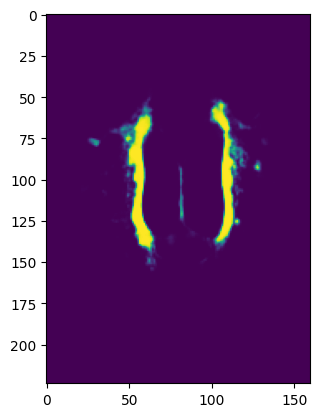

In [169]:
# this image can vary because of the slice sampling!
plt.imshow(x[1][4])

In [28]:
### defining the model

In [52]:
from functools import partial
from typing import Any, Callable, List, Optional, Type, Union

import torch
import torch.nn as nn
from torch import Tensor


def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        channel_size_divide=1,
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64//channel_size_divide
        self.init_inplanes = self.inplanes
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64//channel_size_divide, layers[0])
        self.layer2 = self._make_layer(block, 128//channel_size_divide, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256//channel_size_divide, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512//channel_size_divide, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        #x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    weights,#: Optional[WeightsEnum],
    progress: bool,
    channel_size_divide,
    **kwargs: Any,
) -> ResNet:
    if weights is not None:
        _ovewrite_named_param(kwargs, "num_classes", len(weights.meta["categories"]))

    model = ResNet(block, layers, channel_size_divide, **kwargs)

    if weights is not None:
        model.load_state_dict(weights.get_state_dict(progress=progress))

    return model

def resnet18(*, progress: bool = True, channel_size_divide=2, **kwargs: Any) -> ResNet:
    return _resnet(BasicBlock, [2, 2, 2, 2], None, progress, channel_size_divide=channel_size_divide, **kwargs)

def resnet34(*, progress: bool = True, **kwargs: Any) -> ResNet:

    return _resnet(BasicBlock, [3, 4, 6, 3], None, progress, **kwargs)

In [170]:
### selecting a model

class PredictionModel(torch.nn.Module):
    # uses a modified resnet that bypasses the usual 
    def __init__(self, image_channels, num_slices, num_clin_features, out_classes, latent_fc_features=64):
        super().__init__()
        channel_size_divide = 2
        model_base = resnet18(channel_size_divide=channel_size_divide)
        model_base.conv1 = nn.Conv2d(image_channels*num_slices, model_base.init_inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        
        self.model_base = model_base
        
        # replace the head of the model with another layer.
        
        self.fc1 = nn.Linear(model_base.fc.in_features//channel_size_divide + num_clin_features, latent_fc_features)
        self.a = nn.ReLU()
        self.fc2 = nn.Linear(latent_fc_features, out_classes)
        
    def forward(self, inp):
        
        #xid = {"flair":[0,1,2], "mask": [3,4,5], "t1":[6,7,8], "var": [9,10,11], "ent":[12,13,14], "pred":[15,16,17], "seg":[18,19,20]}
        # flair: 0
        # mask: 1
        # t1: 2
        # ent: 3
        # pred: 4
        # seg: 5
        # var: 6
        
        
        x = inp[0]
        
        # x = x[:, [0, 4, 3]]
        x = x[:, [0, 4]]
        
        # print(x.shape, [*xid["flair"], *xid["pred"]])
        
        clin_data = inp[1]
        
        if x != None:
            features = self.model_base(x)
        else:
            features = torch.zeros(inp[0].shape[0], 512).cuda()
        dense_input = torch.cat([features, clin_data], dim=1)
        
        #print
        
        out = self.fc2(self.a(self.fc1(dense_input)))
        
        return out
        
        

In [171]:
# I will train a model that has access to:

# clin scores
# clin scores + flair + pred seg
# clin scores + flair + pred seg + umap/vmap.
# see how the accuracies of each perform. Nice. its just a prelim test, I don't need to do class re-weighting and all that stuff just yet.

# I will try doing DWMH, PWMH, and then I can try adding in other classes, which can be done by just changing the ClinDataset class to have a differnt label
# so could do Total and tab fazekas. If I can do tab fazekas well then I can predict total SVD better maybe?
# see if the accuracy of the model does any better. I suspect that it might not though...

In [172]:
clin_data.shape

torch.Size([6, 8])

In [173]:
class xent_wrapper(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_loss = torch.nn.CrossEntropyLoss()
    def forward(self, y_hat, y):
        return self.base_loss(y_hat, y.type(torch.long))

In [ ]:
val_results = []
eval_results = []
for i in range(5):
    model_raw = PredictionModel(image_channels=2, num_slices=1, num_clin_features=8, out_classes=4)#.cuda()
    loss = xent_wrapper()
    
    ### training the model
    # setup optimizer and model wrapper

    weight_decay = 0.0001#0.05
    max_epochs = 100
    lr=2e-4
    early_stop_patience = 7

    optimizer_params={"lr":lr, "weight_decay":weight_decay}
    optimizer = torch.optim.Adam
    lr_scheduler_params={"milestones":[1000], "gamma":0.5}
    lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR

    # wrap the model in the pytorch_lightning module that automates training
    model = StandardLitModelWrapper(model_raw, loss, 
                                    logging_metric=lambda : None,
                                    optimizer_params=optimizer_params,
                                    lr_scheduler_params=lr_scheduler_params,
                                    optimizer_constructor=optimizer,
                                    lr_scheduler_constructor=lr_scheduler_constructor
                                   )

    # train the model
    trainer = get_trainer(max_epochs, ".", early_stop_patience=early_stop_patience)
    
    trainer.fit(model, train_dataloader, val_dataloader)
    
    model_results = []
    for _ in range(3):
        result = trainer.validate(model, val_dataloader, ckpt_path='best')
        model_results.append(result[0]['val_loss'])
        
    val_results.append(torch.Tensor(model_results).mean())
    print("val score: ", val_results[-1])
        
    eval_stat = run_eval(model, test_dataloader)
    print("eval stat: ", eval_stat)
    eval_results.append(eval_stat)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params
------------------------------------------
0 | model | PredictionModel | 3.3 M 
1 | loss  | xent_wrapper    | 0     
------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.310    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.438


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.313 >= min_delta = 0.01. New best score: 1.125


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.148 >= min_delta = 0.01. New best score: 0.977


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.109 >= min_delta = 0.01. New best score: 0.869


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 7 records. Best score: 0.869. Signaling Trainer to stop.
Restoring states from the checkpoint path at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/model_load/epoch=3-step=60-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/model_load/epoch=3-step=60-v12.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.8783608675003052
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Restoring states from the checkpoint path at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/model_load/epoch=3-step=60-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/model_load/epoch=3-step=60-v12.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.8756051063537598
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Restoring states from the checkpoint path at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/model_load/epoch=3-step=60-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/model_load/epoch=3-step=60-v12.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.8692261576652527
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
val score:  tensor(0.8744)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:51<00:00,  1.71s/it]

torch.Size([30, 42])


eval stat:  (tensor(0.7619), tensor(0.7750), tensor(0.9410))


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params
------------------------------------------
0 | model | PredictionModel | 3.3 M 
1 | loss  | xent_wrapper    | 0     
------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.310    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.294


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.235 >= min_delta = 0.01. New best score: 1.059


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.221 >= min_delta = 0.01. New best score: 0.838


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 0.01. New best score: 0.815


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.039 >= min_delta = 0.01. New best score: 0.776


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 7 records. Best score: 0.776. Signaling Trainer to stop.
Restoring states from the checkpoint path at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/model_load/epoch=5-step=90-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/model_load/epoch=5-step=90-v6.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.7800176739692688
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Restoring states from the checkpoint path at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/model_load/epoch=5-step=90-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/model_load/epoch=5-step=90-v6.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.7827706336975098
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Restoring states from the checkpoint path at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/model_load/epoch=5-step=90-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/model_load/epoch=5-step=90-v6.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.7837951183319092
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
val score:  tensor(0.7822)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:50<00:00,  1.68s/it]

torch.Size([30, 42])


eval stat:  (tensor(0.8095), tensor(0.8167), tensor(0.9417))


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params
------------------------------------------
0 | model | PredictionModel | 3.3 M 
1 | loss  | xent_wrapper    | 0     
------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.310    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.412


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.307 >= min_delta = 0.01. New best score: 1.105


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.214 >= min_delta = 0.01. New best score: 0.891


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.019 >= min_delta = 0.01. New best score: 0.872


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.032 >= min_delta = 0.01. New best score: 0.839


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 7 records. Best score: 0.839. Signaling Trainer to stop.
Restoring states from the checkpoint path at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/model_load/epoch=5-step=90-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/model_load/epoch=5-step=90-v7.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.8389809727668762
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Restoring states from the checkpoint path at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/model_load/epoch=5-step=90-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/model_load/epoch=5-step=90-v7.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.8408583998680115
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Restoring states from the checkpoint path at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/model_load/epoch=5-step=90-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/model_load/epoch=5-step=90-v7.ckpt


Validation: 0it [00:00, ?it/s]

In [161]:
val_results_mod = torch.Tensor(val_results)[[2, 5, 8, 11, 14]]

In [165]:
val_results_mod, val_results_mod.mean(), (val_results_mod - val_results_mod.mean()).abs().argmin()

(tensor([0.8151, 0.8261, 0.8562, 0.8207, 0.7948]), tensor(0.8226), tensor(3))

In [ ]:
# it seems that models that either perform best or worst on the validation are not best on the test set. the middle of the road model's performance is
# reflected better on the test set. I note that these are results are with augmentation turned OFF for the uncertainty model.
# Now I need to try with no uncertainty map added in.

In [155]:
eval_results

[(tensor(0.7619), tensor(0.7757), tensor(0.9639)),
 (tensor(0.8333), tensor(0.8118), tensor(0.9472)),
 (tensor(0.7143), tensor(0.7368), tensor(0.9472)),
 (tensor(0.7619), tensor(0.7771), tensor(0.9285)),
 (tensor(0.7143), tensor(0.7215), tensor(0.9590))]

In [144]:
result[0]['val_loss']

0.7720934152603149

In [115]:
# so current settings are, t= 0, v= 1, test augmentation is off, validation augmentation is on (augmentation seems to improve test results....)
# validation dataloader is run three times and the average is taken. I want to see if best model on val dataset is best on test dataset or not....

/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/lightning_lite/plugins/environments/slurm.py:167: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/s2208943/miniconda3/envs/uq/lib/python3.10/sit ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params
------------------------------------------
0 | model | PredictionModel | 3.3 M 
1 | loss  | xent_wrapper    | 0     
------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.316    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 15it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.315 >= min_delta = 0.01. New best score: 0.823


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.01. New best score: 0.807


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [131]:
result = trainer.validate(model, val_dataloader, ckpt_path='best')

Restoring states from the checkpoint path at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/model_load/epoch=3-step=75.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/model_load/epoch=3-step=75.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.8035247921943665
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [145]:
result_noaug = trainer.validate(model, val_noaug_dataloader, ckpt_path='best')

Restoring states from the checkpoint path at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/model_load/epoch=7-step=120-v3.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/model_load/epoch=7-step=120-v3.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.7870277762413025
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [146]:
result

[{'val_loss': 0.7720934152603149}]

In [147]:
#os.listdir("/home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/model_load/")

In [148]:
model.model.model_base.conv1

Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [149]:
# so: my three metrics that I want to compute are: top k, mode accuracy form 15 runs, accuracy over 15 runs

In [150]:
f1_metric = torchmetrics.F1Score(task='multiclass', num_classes=4) # note need to set the F1 score correctly depending on the number of classes in the task!!


In [151]:
def run_eval(model, test_dataloader):
    # since the val dataloader does not have shuffle, its actually easy to take the
    # mode...
    all_y_hats = []
    accs = []
    top2_accs = []

    batch_accs = []

    runs = 30
    model.eval()

    for _ in tqdm(range(runs), position=0, leave=True):
        y_hat_preds = []

        for i, ((x, clin_data), y) in enumerate(test_dataloader):
            with torch.no_grad():
                pred = torch.nn.functional.softmax(model.cuda()((x.cuda(), clin_data.cuda())), dim=1).cpu()
                y_hat = pred.argmax(dim=1)

                y_hat_preds += list(y_hat)

                acc = (y == y_hat).sum() / len(y)
                accs.append(acc)

                top2 = pred.topk(dim=1, k=2)[1]
                top2_acc = ((y == top2[:,0]) | (y == top2[:,1])).sum() / len(y)
                top2_accs.append(top2_acc)

        all_y_hats.append(y_hat_preds)

    # calculate the mode accuracy (which is usually higher than mean over multiple runs but can vary quite a bit...
    print(torch.Tensor(all_y_hats).shape)
    mode_preds = torch.Tensor(all_y_hats).mode(dim=0)[0]
    all_ys = []
    for i, ((x, clin_data), y) in enumerate(test_dataloader):
        all_ys += list(y)
    all_ys = torch.Tensor(all_ys)

    mode_acc = (mode_preds == all_ys).sum() / len(all_ys)
    runs_mean_acc = torch.Tensor(accs).mean()
    runs_mean_top2 = torch.Tensor(top2_accs).mean()

    # f1 on mode predictions
    mode_f1 = f1_metric(mode_preds, all_ys)
    return mode_acc, runs_mean_acc, runs_mean_top2

In [152]:
run_eval(model, test_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:50<00:00,  1.69s/it]

torch.Size([30, 42])


(tensor(0.7381), tensor(0.7139), tensor(0.9340))

In [128]:
# this is with + ent
print(f"mode acc: {mode_acc}, run mean acc: {runs_mean_acc}, top-2 acc:{runs_mean_top2}")

mode acc: 0.7857142686843872, run mean acc: 0.78125, top-2 acc:0.9479166865348816


In [50]:
# this is with + ent
print(f"mode acc: {mode_acc}, run mean acc: {runs_mean_acc}, top-2 acc:{runs_mean_top2}")

mode acc: 0.7857142686843872, run mean acc: 0.8194444179534912, top-2 acc:0.9694444537162781


In [48]:
# this is with + ent
print(f"mode acc: {mode_acc}, run mean acc: {runs_mean_acc}, top-2 acc:{runs_mean_top2}")

mode acc: 0.7857142686843872, run mean acc: 0.8159722089767456, top-2 acc:0.973611056804657


In [108]:
# this is with just the seg
print(f"mode acc: {mode_acc}, run mean acc: {runs_mean_acc}, top-2 acc:{runs_mean_top2}")

mode acc: 0.761904776096344, run mean acc: 0.7395833730697632, top-2 acc:0.9791667461395264


In [312]:
# this is with just the seg, another run on same model....
print(f"mode acc: {mode_acc}, run mean acc: {runs_mean_acc}, top-2 acc:{runs_mean_top2}, mode f1: {mode_f1}")

mode acc: 0.738095223903656, run mean acc: 0.7486110925674438, top-2 acc:0.9284722208976746, mode f1: 0.738095223903656


In [280]:
# this is with + ent, another run on the same model....
print(f"mode acc: {mode_acc}, run mean acc: {runs_mean_acc}, top-2 acc:{runs_mean_top2}")

mode acc: 0.7857142686843872, run mean acc: 0.7736110687255859, top-2 acc:0.9576388001441956


In [259]:
# this is with + var map
print(f"mode acc: {mode_acc}, run mean acc: {runs_mean_acc}, top-2 acc:{runs_mean_top2}")

mode acc: 0.761904776096344, run mean acc: 0.7166667580604553, top-2 acc:0.913194477558136


In [138]:
# this is with just the seg, another run on same model....
print(f"mode acc: {mode_acc}, run mean acc: {runs_mean_acc}, top-2 acc:{runs_mean_top2}, mode f1: {mode_f1}")

mode acc: 0.7142857313156128, run mean acc: 0.736111044883728, top-2 acc:0.9395833611488342, mode f1: 0.7142857313156128


In [569]:
a = torch.rand(12, 4)
a.topk(dim=1, k=2)[1][:,1]

tensor([0, 2, 1, 3, 2, 1, 0, 1, 2, 3, 0, 3])

In [ ]:
### changes

# validation and test have no augmentation
# validation is made to repeat over itself 4 times for a less nooisy val choice.
# regularization is increased to 0.05, set a max number of epochs to 30, pick best on val
# pick the mode prediction over 50 runs instead of 30.

# no but sometimes the model fails so we need the val dataloader. so maybe
# I should make the repeats of the val dataloader much bigger, like * 10

In [592]:
# accs = []

# runs = 15
# for _ in range(runs):
#     for (x, clin_data), y in test_dataloader:
#         with torch.no_grad():
#             pred = torch.nn.functional.softmax(model.cuda()((x.cuda(), clin_data.cuda())), dim=1).cpu()
#             acc = (y == pred.argmax(dim=1)).sum() / len(y)
#             print(acc)
#             accs.append(acc)

In [535]:
# this is with + ent (another run, lets see the variance)
torch.stack(accs).mean()

tensor(0.7069)

In [490]:
# this is with + ent
torch.stack(accs).mean()

tensor(0.7292)

In [503]:
# this is with just the seg
torch.stack(accs).mean()

tensor(0.6792)

In [515]:
# this is clin data only
torch.stack(accs).mean()

tensor(0.6042)

In [538]:
# two things. 
# [x] 1) I need to put in all the clinical scores (including volume and damage scores maybe?)
# [ ] 2) I need to cross validate because I'm not sure if the overall results are just quite good when cross validating (and I should compare to 6 fold cross validation of the logistic regression model for a fair comparison)
# [x] 3) I need to compute over the same data a bunch of times and take the mode (and try taking the mode top-k as well for some actually good analysis).
# [ ] 4) I can also try with just a single linear regression layer, that way it matches more with the lgositic regression model I am using.
# [ ] 5) I also need to try predicting other things, such as PVWMH, total fazekas, tab fazekas, and get a whole training pipeline going. Nice.
# [ ] 6) at the earliest opportunity, see if I have statistical significance? Then I know if I am not wasting my time (and compare to just the logistic regression model... 
#    its an interesting result if just a logistic regression models with just mean seg does as well as the nn, like the whole map doesn't really add anything...
# [ ] 7) compare to using the binarized segmentation instead of the pred for the mean model....
# [ ] 8) I was also using age normalized and a total prediction of WMH mass in the logistic regression model..., so those features could actually be useful.... including WMH mass, umap mass etc.
# [ ] 9) the validation dataset effectively changes each iteration and it is small, so the early stopping is very noisy. perhaps I should just take the model after 20 epochs instead and see
# what the difference is, because if it lucks out on epoch two then I'm not gonna get a very good model.
# [x] 10) training with just the clinscores, no extra information.
# [ ] 11) training with a fixed number of epochs (because there is a high level of stochasticity in the early stopping validation score... would also give a bigger test set.... worth a try).
# [ ] 12) using a pretrained model and 'finetuning'.